# Combine datasets together

In [6]:
# Import libraries
import os #operating system
import glob # for reading multiple files
from glob import glob
import pandas as pd #pandas for dataframe management
import matplotlib.pyplot as plt #matplotlib for plotting
import matplotlib.dates as mdates # alias for date formatting
import numpy as np # for generating synthetic data

# datetime stuff
from datetime import date
import holidays

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [7]:
# Set some variables
dataPath = '../data' # set data path
year = 2019

In [8]:
# Define a function to read the data
def read_data(file):
# Read in excel 
    df = (pd.read_excel(
        file,
        skiprows=range(1,9),
        usecols='B:C',
        header=0,
    ))

    # remove last rows
    df.drop(
        df.tail(2).index,
        inplace=True
    )

    # fix index and naming
    df.columns = ['date', 'demand']
    df['date'] = pd.to_datetime(df['date']) # convert column to datetime
    df.set_index('date', inplace=True)

    return df

# Read all the data

In [9]:
# Create a list of files to combine
PATH = dataPath
EXT = "*.xls"
all_files = [file
            for path, subdir, files in os.walk(PATH)
            for file in glob(os.path.join(path, EXT))]

# Assemble files into a final dataframe
df = pd.DataFrame()
for file in all_files:
    tmp = read_data(file)
    dfs = [df, tmp]
    df = pd.concat(dfs)

# Data processing

In [10]:
df.sort_index(inplace=True)
df['demand'] = df['demand'].apply(pd.to_numeric, errors='coerce')

ts_daily = df.resample('D').mean()
days = ts_daily.index.strftime("%Y-%m-%d")

ts_monthly = df.resample('M').mean()
months = ts_monthly.index.strftime("%Y-%m")

## Daily

In [11]:
def create_date_labels(df):
    """ Function to create day labels that could be useful for plotting
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['month_name'] = df.index.month_name()
    df['day_name'] = df.index.day_name()

    return df

In [12]:
ts_daily = create_date_labels(ts_daily)

### Filter by weekends and holidays

In [13]:
# Check the holidays resolving
brazil_holidays = holidays.Brazil()
for ptr in holidays.Brazil(years = 2019).items():
    print(ptr)

(datetime.date(2019, 1, 1), 'Ano novo')
(datetime.date(2019, 4, 21), 'Páscoa, Tiradentes')
(datetime.date(2019, 5, 1), 'Dia Mundial do Trabalho')
(datetime.date(2019, 9, 7), 'Independência do Brasil')
(datetime.date(2019, 10, 12), 'Nossa Senhora Aparecida')
(datetime.date(2019, 11, 2), 'Finados')
(datetime.date(2019, 11, 15), 'Proclamação da República')
(datetime.date(2019, 12, 25), 'Natal')
(datetime.date(2019, 4, 19), 'Sexta-feira Santa')
(datetime.date(2019, 6, 20), 'Corpus Christi')
(datetime.date(2019, 3, 6), 'Quarta-feira de cinzas (Início da Quaresma)')
(datetime.date(2019, 3, 5), 'Carnaval')


In [14]:
# reset index and convert timestamp to date
ts_daily.reset_index(inplace=True)
ts_daily['date'] = ts_daily['date'].apply(lambda x: x.date())
ts_daily['holiday'] = ts_daily['date'].apply(lambda x: x in brazil_holidays)
ts_daily.set_index('date', inplace=True)

In [15]:
ts_daily.head()

,demand,year,month,day,weekday,month_name,day_name,holiday
date,,,,,,,,
2019-01-01,36.833684,2019,1,1,1,January,Tuesday,True
2019-01-02,42.563368,2019,1,2,2,January,Wednesday,False
2019-01-03,49.657263,2019,1,3,3,January,Thursday,False
2019-01-04,69.544421,2019,1,4,4,January,Friday,False
2019-01-05,47.747368,2019,1,5,5,January,Saturday,False


In [16]:
# Check
ts_daily.loc[ts_daily['weekday'] < 5] # Weekday
ts_daily.loc[ts_daily['weekday'] >= 5] # Weekend
ts_daily.loc[ts_daily['holiday'] == True] # Holiday

,demand,year,month,day,weekday,month_name,day_name,holiday
date,,,,,,,,
2019-01-01,36.833684,2019,1,1,1,January,Tuesday,True
2019-03-05,66.447835,2019,3,5,1,March,Tuesday,True
2019-03-06,73.900206,2019,3,6,2,March,Wednesday,True
2019-04-19,40.498144,2019,4,19,4,April,Friday,True
2019-04-21,47.653608,2019,4,21,6,April,Sunday,True
2019-05-01,39.340206,2019,5,1,2,May,Wednesday,True
2019-06-20,44.268866,2019,6,20,3,June,Thursday,True
2019-09-07,73.187629,2019,9,7,5,September,Saturday,True
2019-10-12,58.876701,2019,10,12,5,October,Saturday,True


# Plotting

In [17]:
import seaborn as sns # plotting library
sns.set(rc={'figure.figsize':(11, 4)})

<AxesSubplot:xlabel='date'>

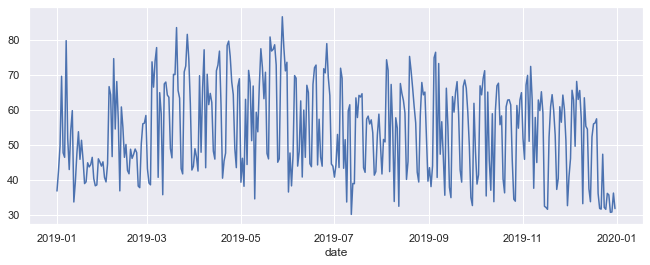

In [18]:
# Basic quick plot
ts_daily['demand'].plot()

<AxesSubplot:xlabel='date'>

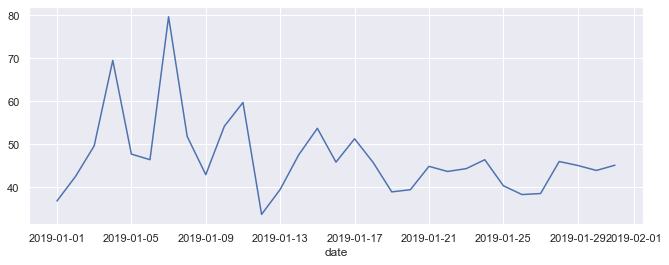

In [19]:
ts_daily.loc[ts_daily['month_name'] == 'January', 'demand'].plot()

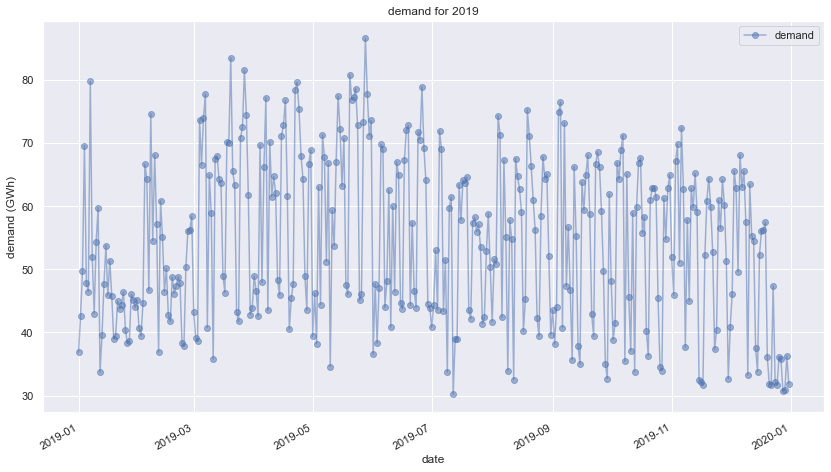

In [20]:
# plot with more customization
cols_plot = ['demand']
timerange = '2019'
axes = ts_daily[cols_plot].plot(
    marker='o',
    alpha=0.5,
    linestyle='-',
    figsize=(14, 8),
    subplots=True)
for ax in axes:
    ax.set_ylabel('demand (GWh)')
    ax.set_title(f'demand for {timerange}')

In [21]:
def plotBox(df, col='demand', grp='month_name'):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8), sharex=True)
    sns.boxplot(data=df, x=grp, y=col, ax=ax)
    ax.set_label(f'{col}')
    ax.set_title(f'boxplot for year {year}')
    ax.set_xlabel('')

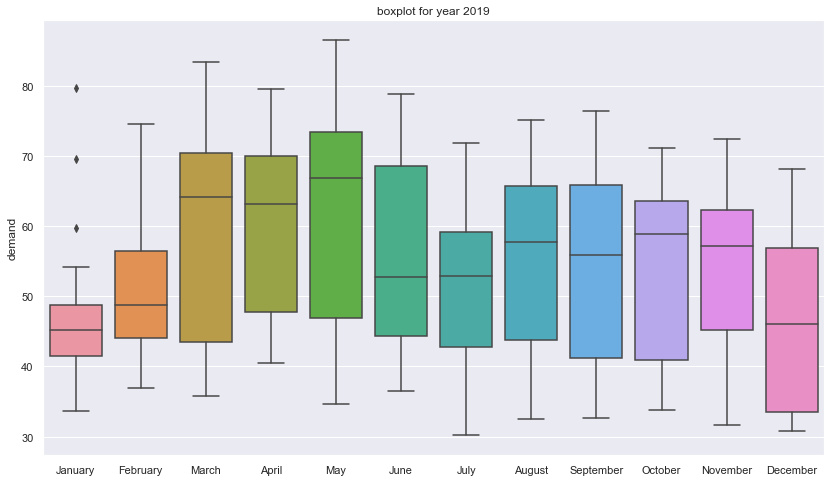

In [22]:
# all data
plotBox(ts_daily, 'demand')

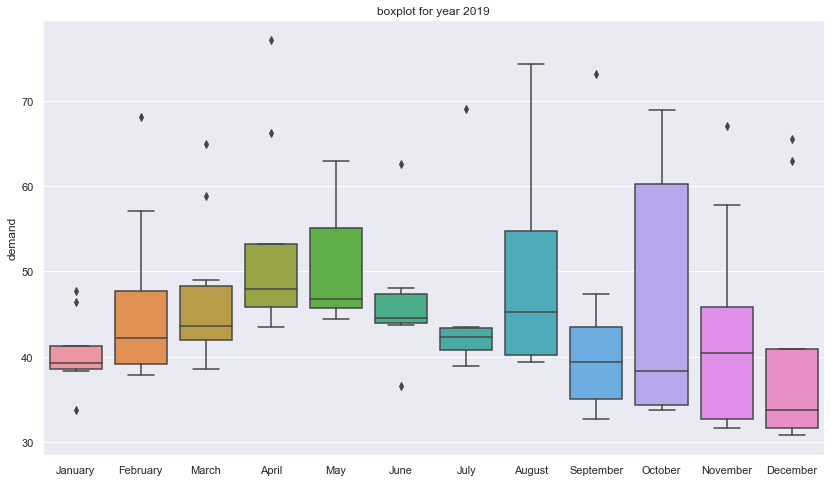

In [23]:
# Weekend
plotBox(ts_daily.loc[ts_daily['weekday'] >= 5], 'demand')

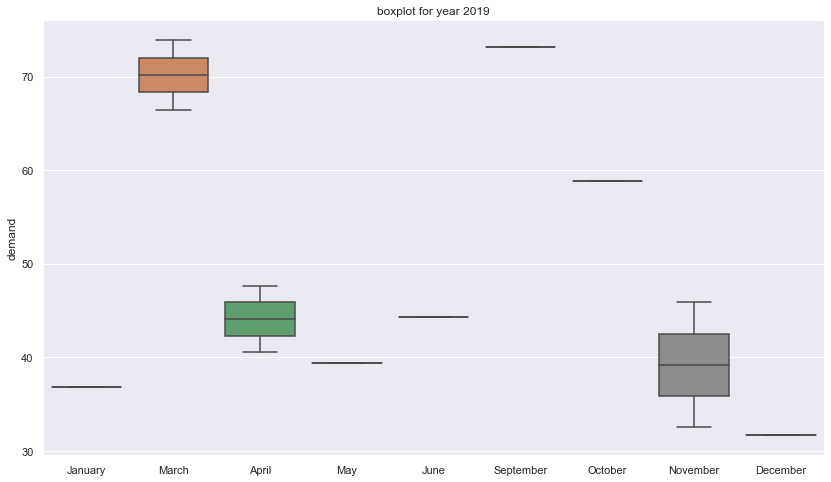

In [24]:
# holiday
plotBox(ts_daily.loc[ts_daily['holiday'] == True], 'demand')

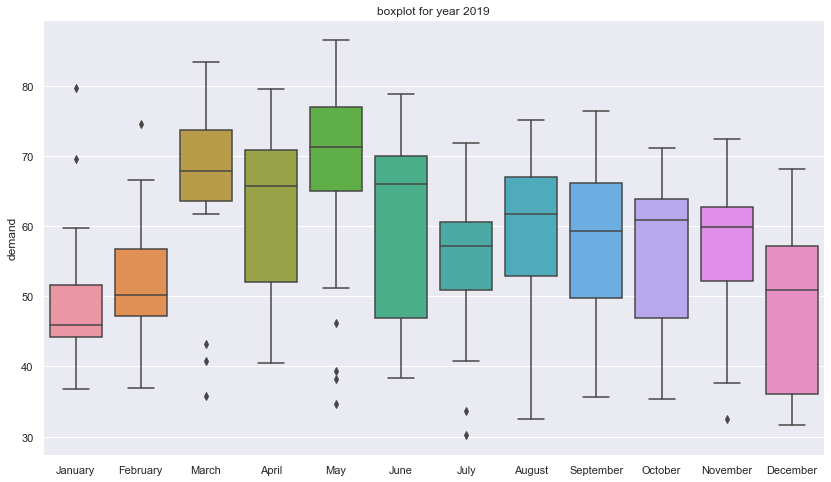

In [25]:
# weekday
plotBox(ts_daily.loc[ts_daily['weekday'] < 5], 'demand')

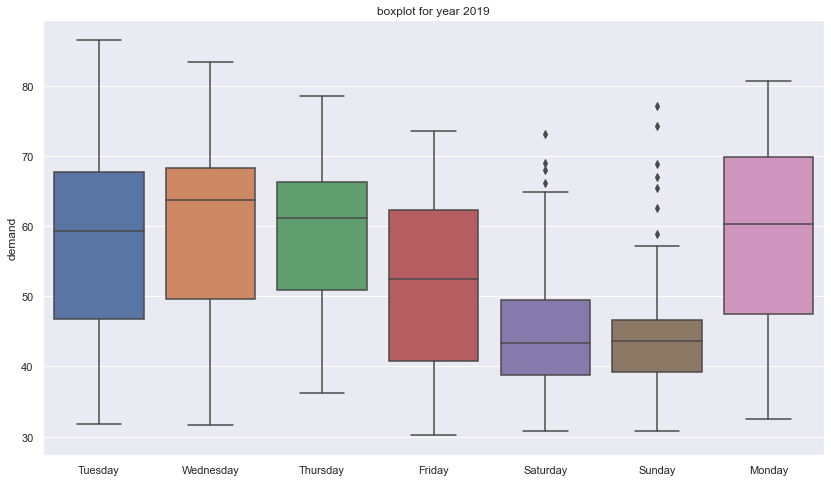

In [26]:
plotBox(ts_daily, col='demand', grp='day_name')